<center>
    <img src="https://gitlab.com/ibm/skills-network/courses/placeholder101/-/raw/master/labs/module%201/images/IDSNlogo.png" width="300" alt="cognitiveclass.ai logo"  />
</center>


# **Machine Learning with Apache Spark ML**


Estimated time needed: **15** minutes


This lab goes introduces Machine Learning using Spark ML Lib (sparkml).


![](http://spark.apache.org/images/spark-logo.png)


## Objectives


Spark ML Library is also commonly called MLlib and is used to perform machine learning operations using DataFrame-based APIs.

After completing this lab you will be able to:


*   Import the Spark ML and Statistics Libraries
*   Perform basic statistics operations using Spark
*   Build a simple linear regression model using Spark ML
*   Train the model and perform evaluation


***


## Setup


For this lab, we are going to be using Python and Spark (pyspark). These libraries should be installed in your lab environment or in SN Labs.


In [1]:
# Pandas is a popular data science package for Python. In this lab, we use Pandas to load a CSV file from disc to a pandas dataframe in memory.
import pandas as pd
import matplotlib.pyplot as plt
# pyspark is the Spark API for Python. In this lab, we use pyspark to initialize the spark context. 
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession

Waiting for a Spark session to start...
Spark Initialization Done! ApplicationId = app-20220120203252-0000
KERNEL_ID = 8e78c925-1ae2-46dc-b2b2-17e4c5a62cd1


## Exercise 1 -  Spark session


In this exercise, you will create and initialize the Spark session needed to load the dataframes and operate on it


#### Task 1: Creating the spark session and context


In [5]:
# Creating a spark context class
sc = SparkContext()

# Creating a spark session
spark = SparkSession \
    .builder \
    .appName("Python Spark DataFrames basic example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

ValueError: Cannot run multiple SparkContexts at once; existing SparkContext(app=python3.7, master=spark://jkg-deployment-8e78c925-1ae2-46dc-b2b2-17e4c5a62cd1-797589r8vpv:7077) created by getOrCreate at /opt/ibm/kernelScript/python/shell.py:69 

#### Task 2: Initialize Spark session

To work with dataframes we just need to verify that the spark session instance has been created.
Feel free to click on the "Spark UI" button to explore the Spark UI elements.


In [6]:
spark

#### Task 2: Importing Spark ML libraries

In this exercise we will import 4 SparkML functions.

1.  (Feature library) VectorAssembler(): This function is used to create feature vectors from dataframes/raw data. These feature vectors are required to train a ML model or perform any statistical operations.
2.  (Stat library) Correlation(): This function is from the statistics library within SparkML. This function is used to calculate correlation between feature vectors.
3.  (Feature library) Normalized(): This function is used to normalize features. Normalizing features leads to better ML model convergence and training results.
4.  (Regression Library) LinearRegression(): This function is used to create a Linear Regression model and train it.


In [8]:
from pyspark.ml.feature import VectorAssembler, Normalizer, StandardScaler
from pyspark.ml.stat import Correlation
from pyspark.ml.regression import LinearRegression

## Exercise 2 - Loading the data and Creating Feature Vectors


In this section, you will first read the CSV file into a pandas dataframe and then read it into a Spark dataframe

Pandas is a library used for data manipulation and analysis. Pandas offers data structures and operations for creating and manipulating Data Series and DataFrame objects. Data can be imported from various data sources, e.g., Numpy arrays, Python dictionaries and CSV files. Pandas allows you to manipulate, organize and display the data.

In this example we use a dataset that contains information about cars.


#### Task 1: Loading data into a Pandas DataFrame


In [9]:
# Read the file using `read_csv` function in pandas
cars = pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-BD0225EN-SkillsNetwork/labs/data/cars.csv')

In [10]:
# Preview a few records
cars.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model,origin,car_name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


For this example, we pre process the data and only use 3 columns. This preprocessed dataset can be found in the `cars2.csv` file.


In [11]:
cars2 = pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-BD0225EN-SkillsNetwork/labs/data/cars2.csv', header=None, names=["mpg", "hp", "weight"])
cars2.head()

,mpg,hp,weight
0,18.0,130.0,3504.0
1,15.0,165.0,3693.0
2,18.0,150.0,3436.0
3,16.0,150.0,3433.0
4,17.0,140.0,3449.0


#### Task 2: Loading data into a Spark DataFrame


In [12]:
# We use the `createDataFrame` function to load the data into a spark dataframe
sdf = spark.createDataFrame(cars2)

In [13]:
# Let us look at the schema of the loaded spark dataframe
sdf.printSchema()

root
 |-- mpg: double (nullable = true)
 |-- hp: double (nullable = true)
 |-- weight: double (nullable = true)



#### Task 3: Converting data frame columns into feature vectors

In this task we use the `VectorAssembler()` function to convert the dataframe columns into feature vectors.
For our example, we use the horsepower ("hp) and weight of the car as input features and the miles-per-gallon ("mpg") as target labels.


In [14]:
assembler = VectorAssembler(
    inputCols=["hp", "weight"],
    outputCol="features")

output = assembler.transform(sdf).select('features','mpg')

We now create a test-train split of 75%-25%


In [15]:
train, test = output.randomSplit([0.75, 0.25])

## Exercise 3 - Basic stats and feature engineering


In this exercise, we determine the correlation between feature vectors and normalize the features.


#### Task 1: Correlation

Spark ML has inbuilt Correlation function as part of the Stat library. We use the correlation function to determine the different types of correlation between the 2 features - "hp" and "weight".


In [16]:
r1 = Correlation.corr(train, "features").head()
print("Pearson correlation matrix:\n" + str(r1[0]))

Pearson correlation matrix:
DenseMatrix([[1.        , 0.86611785],
             [0.86611785, 1.        ]])


In [17]:
r2 = Correlation.corr(train, "features", "spearman").head()
print("Spearman correlation matrix:\n" + str(r2[0]))

Spearman correlation matrix:
DenseMatrix([[1.       , 0.8821058],
             [0.8821058, 1.       ]])


We can see that there is a 0.86 (or 86%) correlation between the features. That is logical as a car with higher horsepower likely has a bigger engine and thus weighs more. We can also visualize the feature vectors to see that they are indeed correlated.


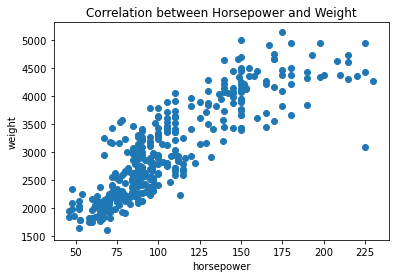

In [18]:
plt.figure()
plt.scatter(cars2["hp"], cars2["weight"])
plt.xlabel("horsepower")
plt.ylabel("weight")
plt.title("Correlation between Horsepower and Weight")
plt.show()

#### Task 2: Normalization

In order for better model training and convergence, it is a good practice to normalize feature vectors.


In [19]:
normalizer = Normalizer(inputCol="features", outputCol="features_normalized", p=1.0)
train_norm = normalizer.transform(train)
print("Normalized using L^1 norm")
train_norm.show(5, truncate=False)

Normalized using L^1 norm
+-------------+----+-----------------------------------------+
|features     |mpg |features_normalized                      |
+-------------+----+-----------------------------------------+
|[46.0,1835.0]|26.0|[0.024455077086656035,0.9755449229133439]|
|[46.0,1950.0]|26.0|[0.023046092184368736,0.9769539078156313]|
|[49.0,1867.0]|29.0|[0.0255741127348643,0.9744258872651357]  |
|[52.0,2035.0]|29.0|[0.024916147580258743,0.9750838524197413]|
|[53.0,1795.0]|33.0|[0.02867965367965368,0.9713203463203464] |
+-------------+----+-----------------------------------------+
only showing top 5 rows



#### Task 2: Standard Scaling

This is a standard practice to scale the features such that all columns in the features have zero mean and unit variance.


In [20]:
standard_scaler = StandardScaler(inputCol="features", outputCol="features_scaled")
train_model = standard_scaler.fit(train)
train_scaled = train_model.transform(train)
train_scaled.show(5, truncate=False)

+-------------+----+---------------------------------------+
|features     |mpg |features_scaled                        |
+-------------+----+---------------------------------------+
|[46.0,1835.0]|26.0|[1.1691110855248021,2.1152009754348637]|
|[46.0,1950.0]|26.0|[1.1691110855248021,2.24776125454931]  |
|[49.0,1867.0]|29.0|[1.245357460667724,2.1520873139710575] |
|[52.0,2035.0]|29.0|[1.3216038358106459,2.345740591286075] |
|[53.0,1795.0]|33.0|[1.34701929419162,2.0690930522646216]  |
+-------------+----+---------------------------------------+
only showing top 5 rows



In [21]:
test_scaled = train_model.transform(test)
test_scaled.show(5, truncate=False)

+-------------+----+---------------------------------------+
|features     |mpg |features_scaled                        |
+-------------+----+---------------------------------------+
|[52.0,1649.0]|31.0|[1.3216038358106459,1.9007991326932372]|
|[54.0,2254.0]|23.0|[1.3724347525725937,2.5981814706431514]|
|[67.0,2000.0]|31.0|[1.7028357115252553,2.305396158512113] |
|[70.0,1937.0]|29.0|[1.7790820866681771,2.2327761795189813]|
|[72.0,2401.0]|21.0|[1.829913003430125,2.7676280882937916] |
+-------------+----+---------------------------------------+
only showing top 5 rows



## Exercise 4 - Building and Training a Linear Regression Model


In this exercise, we train a Linear Regression model `lrModel` on our training dataset. We train the model on the standard scaled version of features.
We also print the final RMSE and R-Squared metrics.


#### Task 1: Create and Train model

We can create the model using the `LinearRegression()` class and train using the `fit()` function.


In [22]:
# Create a LR model
lr = LinearRegression(featuresCol='features_scaled', labelCol='mpg', maxIter=100)

# Fit the model
lrModel = lr.fit(train_scaled)

# Print the coefficients and intercept for linear regression
print("Coefficients: %s" % str(lrModel.coefficients))
print("Intercept: %s" % str(lrModel.intercept))

# Summarize the model over the training set and print out some metrics
trainingSummary = lrModel.summary
#trainingSummary.residuals.show()
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("R-squared: %f" % trainingSummary.r2)

Coefficients: [-2.0057079640595386,-5.069303780720131]
Intercept: 46.438431086267535
RMSE: 4.265232
R-squared: 0.721646


We see a RMSE (Root mean squared error) of 4.26. This means that our model predicts the `mpg` with an average error of 4.2 units.


#### Task 2: Predict on new data

Once a model is trained, we can then `transform()` new unseen data (for eg. the test data) to generate predictions.
In the below cell, notice the "prediction" column that contains the predicted "mpg".


In [23]:
lrModel.transform(test_scaled).show(5)

+-------------+----+--------------------+------------------+
|     features| mpg|     features_scaled|        prediction|
+-------------+----+--------------------+------------------+
|[52.0,1649.0]|31.0|[1.32160383581064...| 34.15195151769912|
|[54.0,2254.0]|23.0|[1.37243475257259...|30.514756620752284|
|[67.0,2000.0]|31.0|[1.70283571152525...|31.336286475773218|
|[70.0,1937.0]|29.0|[1.77908208666817...| 31.55149124798409|
|[72.0,2401.0]|21.0|[1.82991300343012...|28.738212470136677|
+-------------+----+--------------------+------------------+
only showing top 5 rows



### Question 1 - Correlation


Print the correlation matrix for the test dataset split we created above.


In [24]:
# Code block for learners to answer
r1 = Correlation.corr(test, "features").head()
print("Pearson correlation matrix:\n" + str(r1[0]))


Double-click **here** for the solution.

<!-- The answer is below:

r1 = Correlation.corr(test, "features").head()
print("Pearson correlation matrix:\n" + str(r1[0]))

-->


### Question 2 - Feature Normalization


Normalize the training features by using the L2 norm of the feature vector.


In [31]:
# Code block for learners to answer
normalizer_l2 = Normalizer(inputCol="features", outputCol="features_normalized", p=2.0)
train_norm_l2 = normalizer_l2.transform(train)
print("Normalized using L^1 norm\n"+str(train_norm_l2))
train_norm_l2.show(5, truncate=False)

Normalized using L^1 norm
DataFrame[features: vector, mpg: double, features_normalized: vector]
+-------------+----+-----------------------------------------+
|features     |mpg |features_normalized                      |
+-------------+----+-----------------------------------------+
|[46.0,1835.0]|26.0|[0.025060247064771873,0.9996859426925301]|
|[46.0,1950.0]|26.0|[0.023583182764714966,0.9997218780694388]|
|[49.0,1867.0]|29.0|[0.02623627890186543,0.9996557695874032] |
|[52.0,2035.0]|29.0|[0.025544487316886973,0.9996736863435576]|
|[53.0,1795.0]|33.0|[0.029513600043251785,0.9995643788233387]|
+-------------+----+-----------------------------------------+
only showing top 5 rows



Double-click **here** for the solution.

<!-- The answer is below:

normalizer_l2 = Normalizer(inputCol="features", outputCol="features_normalized", p=2.0)
train_norm_l2 = normalizer_l2.transform(train)
rint("Normalized using L^1 norm\n"+str(train_norm_l2))
train_norm_l2.show(5, truncate=False)

-->


### Question 3 - Train Model


Repeat the model training shown above for another 100 iterations and report the coefficients.


In [35]:
# Code block for Question 3
normalizer_l2 = Normalizer(inputCol="features", outputCol="features_normalized", p=2.0)
train_norm_l2 = normalizer_l2.transform(train)
print("Normalized using L^1 norm\n"+str(train_norm_l2))
train_norm_l2.show(100, truncate=False)

Normalized using L^1 norm
DataFrame[features: vector, mpg: double, features_normalized: vector]
+--------------+----+-----------------------------------------+
|features      |mpg |features_normalized                      |
+--------------+----+-----------------------------------------+
|[46.0,1835.0] |26.0|[0.025060247064771873,0.9996859426925301]|
|[46.0,1950.0] |26.0|[0.023583182764714966,0.9997218780694388]|
|[49.0,1867.0] |29.0|[0.02623627890186543,0.9996557695874032] |
|[52.0,2035.0] |29.0|[0.025544487316886973,0.9996736863435576]|
|[53.0,1795.0] |33.0|[0.029513600043251785,0.9995643788233387]|
|[60.0,1834.0] |27.0|[0.032697882702442616,0.9994652812713293]|
|[60.0,2164.0] |24.5|[0.027715781255455544,0.9996158439467633]|
|[61.0,2003.0] |32.0|[0.03044020567321263,0.9995365895646704] |
|[65.0,1773.0] |31.0|[0.03663641453982059,0.9993286612169524] |
|[65.0,1836.0] |32.0|[0.0353808842774419,0.9993739005135897]  |
|[67.0,1950.0] |31.0|[0.03433871124160268,0.9994102525541079] |
|[67.0,1

## Authors


[Karthik Muthuraman](https://www.linkedin.com/in/karthik-muthuraman/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMBD0231ENSkillsNetwork26766988-2021-01-01)


### Other Contributors


[Jerome Nilmeier](https://github.com/nilmeier/)


## Change Log


| Date (YYYY-MM-DD) | Version | Changed By    | Change Description      |
| ----------------- | ------- | ------------- | ----------------------- |
| 2021-12-22        | 0.3     | Lakshmi Holla | Made changes in scaling |
| 2021-08-05        | 0.2     | Azim          | Beta launch             |
| 2021-07-01        | 0.1     | Karthik       | Initial Draft           |


Copyright © 2021 IBM Corporation. All rights reserved.
